In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import pre
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
import re

In [2]:
# ! pip install imblearn

In [3]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.shape

(891, 12)

In [6]:
test.shape

(418, 11)

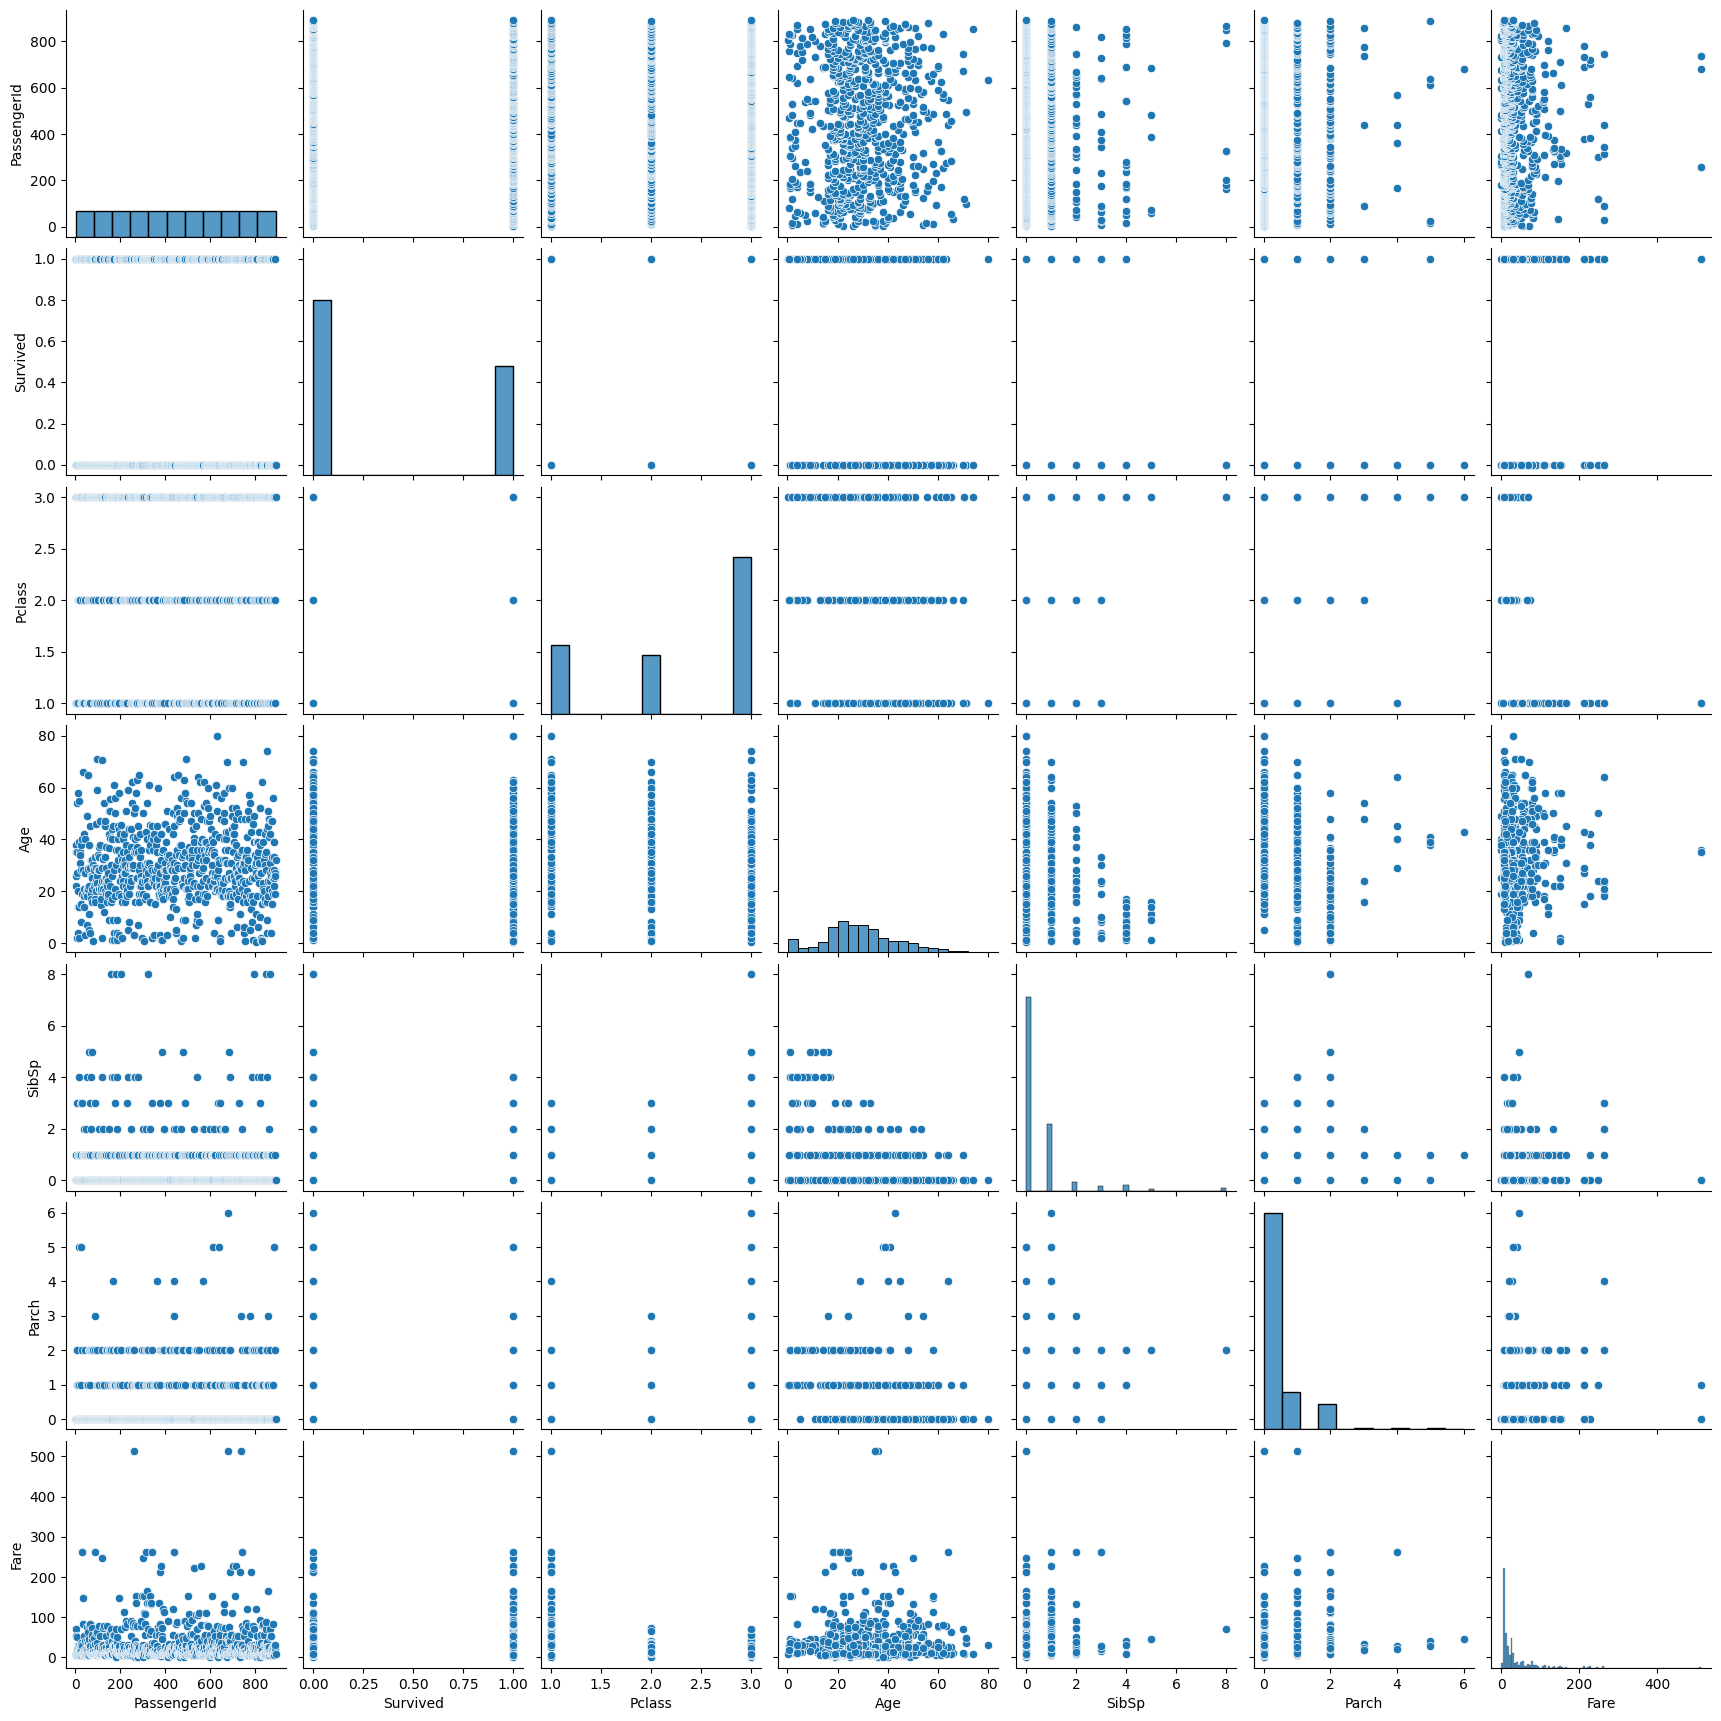

In [7]:
sns.pairplot(train)  # Replace df with your DataFrame
plt.show()

In [8]:
train_X = train[['Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']]
test_X = test[['Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']]

train_y = train['Survived']

In [9]:
train_X = train_X.drop(['Ticket'], axis=1)
test_X = test_X.drop(['Ticket'], axis=1)



In [10]:
nan_rows = train_X[train_X.isna().any(axis=1)]

In [11]:
nan_rows

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S
5,3,"Moran, Mr. James",male,NaN,0,0,8.4583,NaN,Q
7,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...
884,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,7.0500,NaN,S
885,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,29.1250,NaN,Q
886,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,NaN,S
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,NaN,S


In [12]:
def age_nan_values(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    return df

def fare_nan_values(df):
    df['Fare'].fillna(df['Fare'].mean(), inplace=True)
    return df

def cabin_nan_values(df):
    df['Cabin'] = df['Cabin'].isna().astype(int)
    return df

def embarked_nan_values(df):
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    return df
def nan_values(df):
    df = age_nan_values(df)
    
    df = cabin_nan_values(df)

    df = embarked_nan_values(df)

    df = fare_nan_values(df)

    return df

def encode_gender(df):
    df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
    return df

def encode_embarked(df):
    df = pd.get_dummies(df, columns=['Embarked'], dtype=int)
    return df

def prepare_data(df):
    df = nan_values(df)
    df = encode_gender(df)
    df = encode_embarked(df)
    return df




In [13]:
def encode_names(df):
    df['Name'] = [re.search(r", ([A-Za-z ]+)\.", name).group(1) if re.search(r", ([A-Za-z ]+)\.", name) else name for name in df['Name']]
    df = pd.get_dummies(df, columns=['Name'], dtype=int)
    return df

def process_and_split(train_df, test_df):
    # Add a column to identify the original dataset
    train_df["is_train"] = 1
    test_df["is_train"] = 0

    # Combine datasets
    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    # Encode names
    combined_df = encode_names(combined_df)

    # Split them back
    train_df = combined_df[combined_df["is_train"] == 1].drop(columns=["is_train"])
    test_df = combined_df[combined_df["is_train"] == 0].drop(columns=["is_train"])

    return train_df, test_df

In [14]:
train_X = prepare_data(train_X)
test_X = prepare_data(test_X)

train_X, test_X = process_and_split(train_X, test_X)

/var/folders/_v/wtqndz5s2cqc5nfy735t040h0000gn/T/ipykernel_27303/37944882.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace=True)
/var/folders/_v/wtqndz5s2cqc5nfy735t040h0000gn/T/ipykernel_27303/37944882.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

In [15]:
def smote_tomek(X, y):
    smt = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smt.fit_resample(X, y)

    return X_resampled, y_resampled

def smote(X, y):
    smt = SMOTE(random_state=42)
    X_resampled, y_resampled = smt.fit_resample(X, y)

    return X_resampled, y_resampled

In [16]:
def train_random_forrest(X_train, y_train, val_X, val_y):
    # Split features and target
    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize numeric features
        ('classifier', RandomForestClassifier(random_state=42))  # Model
    ])

    # Define hyperparameters to tune
    param_grid = {
        'classifier__n_estimators': range(50, 500, 40),  # Number of trees
        'classifier__max_depth': [None, 10, 20, 30, 40],  # Maximum depth of trees
        'classifier__min_samples_split': [2, 5, 10, 15, 20]  # Minimum samples to split
    }

    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    val_score = grid_search.best_estimator_.score(val_X, val_y)

    return grid_search.best_estimator_, val_score

In [17]:
def train_svc(X_train, y_train, val_X, val_y):
    """
    Trains an SVM (SVC) model with hyperparameter tuning.
    """
    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize numeric features
        ('classifier', SVC())
    ])

    # Define hyperparameters for tuning
    param_grid = {
        'classifier__C': np.arange(0.1, 8, 0.3),
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }

    # Perform hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Evaluate on val_X, val_y
    val_score = grid_search.best_estimator_.score(val_X, val_y)

    return grid_search.best_estimator_, val_score

In [18]:
def train_knn(X_train, y_train, val_X, val_y):
    """
    Trains a KNN classifier with hyperparameter tuning.
    """
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize features
        ('classifier', KNeighborsClassifier())
    ])

    param_grid = {
        'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]  # 1: Manhattan, 2: Euclidean
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    val_score = grid_search.best_estimator_.score(val_X, val_y)

    return grid_search.best_estimator_, val_score

In [19]:
def train_decision_tree(X_train, y_train, val_X, val_y):
    """
    Trains a Decision Tree classifier without scaling.
    """
  
    pipeline = Pipeline([
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])

    param_grid = {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    val_score = grid_search.best_estimator_.score(val_X, val_y)

    return grid_search.best_estimator_, val_score

In [20]:
def train_xgboost(X_train, y_train, val_X, val_y):
    """
    Trains an XGBoost classifier with hyperparameter tuning.
    """
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # XGBoost benefits from scaled input
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])

    param_grid = {
        'classifier__n_estimators': range(50, 500, 50),
        'classifier__max_depth': [3, 5, 7, 9, 11],
        'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'classifier__subsample': [0.6, 0.8, 1.0]
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    val_score = grid_search.best_estimator_.score(val_X, val_y)

    return grid_search.best_estimator_, val_score

In [21]:
X_train, val_X, y_train, val_y = train_test_split(train_X, train_y, test_size=0.25, random_state=42)

#X_train, y_train = smote(X_train, y_train)


In [22]:
best_model_dt, val_dt = train_decision_tree(X_train, y_train, val_X, val_y)
best_model_knn, val_knn = train_knn(X_train, y_train, val_X, val_y)
best_model_rf, val_rf = train_random_forrest(X_train, y_train, val_X, val_y)
best_model_svc, val_svc = train_svc(X_train, y_train, val_X, val_y)
best_model_xg, val_xg = train_xgboost(X_train, y_train, val_X, val_y)

/Users/steffanschoonbee/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [09:35:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/steffanschoonbee/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [09:35:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/steffanschoonbee/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [09:35:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/steffanschoonbee/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [09:35:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encod

In [23]:
test_X

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,...,Name_Master,Name_Miss,Name_Mlle,Name_Mme,Name_Mr,Name_Mrs,Name_Ms,Name_Rev,Name_Sir,Name_the Countess
891,3,1,34.50000,0,0,7.8292,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
892,3,0,47.00000,1,0,7.0000,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
893,2,1,62.00000,0,0,9.6875,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
894,3,1,27.00000,0,0,8.6625,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
895,3,0,22.00000,1,1,12.2875,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,1,30.27259,0,0,8.0500,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1305,1,0,39.00000,0,0,108.9000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1306,3,1,38.50000,0,0,7.2500,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1307,3,1,30.27259,0,0,8.0500,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [46]:
models = {
    'Decision Tree': (best_model_dt, val_dt),
    'KNN': (best_model_knn, val_knn),
    'Random Forest': (best_model_rf, val_rf),
    'SVC': (best_model_svc, val_svc),
    'XGBoost': (best_model_xg, val_xg)
}

# Find the best model based on validation accuracy
best_model_name, (best_model, best_val_score) = max(models.items(), key=lambda x: x[1][1])

# Predict on test_X using the best model
test_predictions = best_model.predict(test_X)

# Output results
print(f"Best Model: {best_model_name} with Validation Score: {best_val_score:.4f}")

Best Model: KNN with Validation Score: 0.8296


In [47]:
test_predictions

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [48]:
final = pd.DataFrame({'PassengerId' : test['PassengerId'] , 'Survived' : test_predictions})

In [49]:
final.to_csv("../data/predictions.csv", index=False)

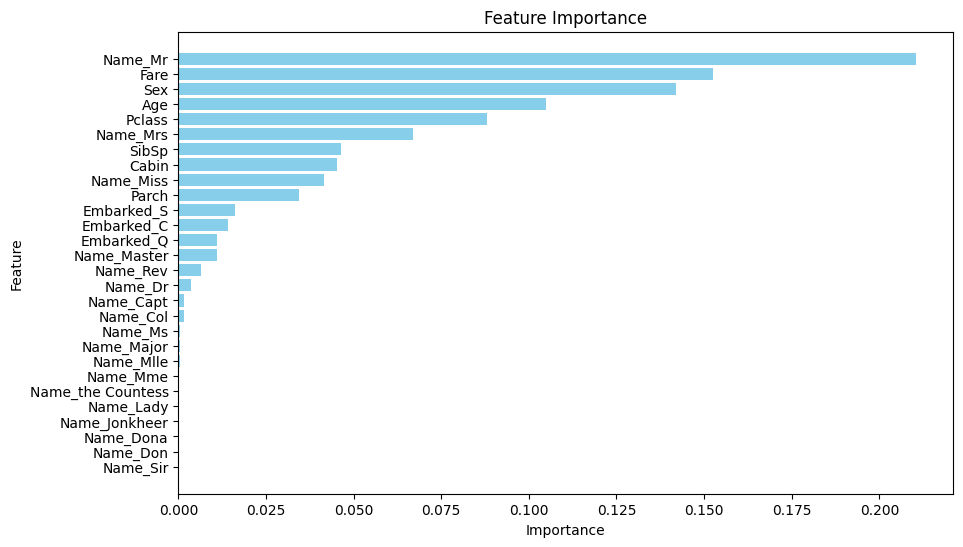

In [43]:
best_model_rf_clf = best_model_rf.named_steps['classifier']  # Change to best_model_dt.named_steps['classifier'] for Decision Tree

# Get feature importance
feature_importance = best_model_rf_clf.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({'Feature': train_X.columns, 'Importance': feature_importance})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at top
plt.show()

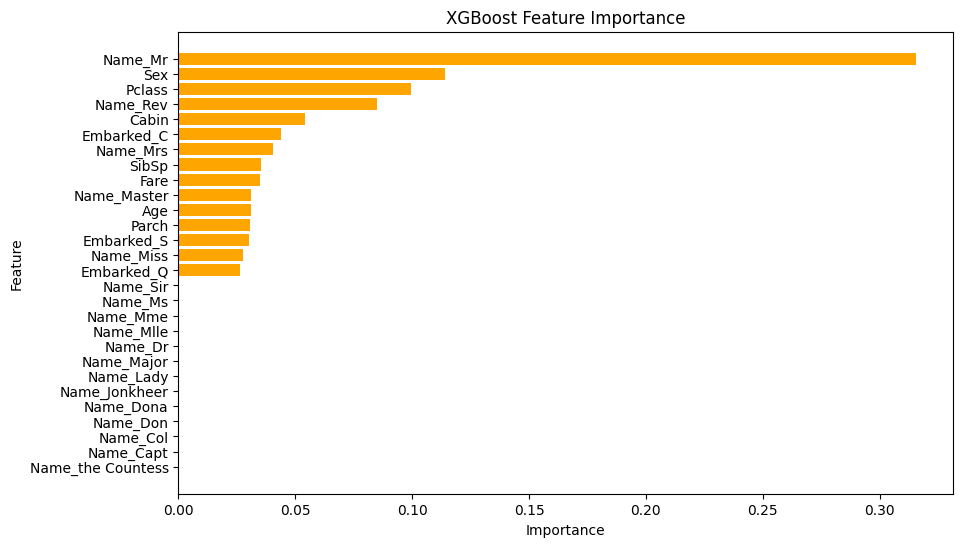

In [44]:
best_model_xg_clf = best_model_xg.named_steps['classifier']  # Extract XGBoost classifier

# Get feature importance
feature_importance = best_model_xg_clf.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({'Feature': train_X.columns, 'Importance': feature_importance})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'], color='orange')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Testing stuff out here 

In [28]:
names = train['Name']

In [29]:
title = ['Rev.', 'Mr.', 'Miss', 'Mrs.', 'Master.']

In [30]:
names

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [31]:
titles = [re.search(r", (\w+)\.", name).group(1) for name in names if re.search(r", (\w+)\.", name)]

print(titles)

['Mr', 'Mrs', 'Miss', 'Mrs', 'Mr', 'Mr', 'Mr', 'Master', 'Mrs', 'Mrs', 'Miss', 'Miss', 'Mr', 'Mr', 'Miss', 'Mrs', 'Master', 'Mr', 'Mrs', 'Mrs', 'Mr', 'Mr', 'Miss', 'Mr', 'Miss', 'Mrs', 'Mr', 'Mr', 'Miss', 'Mr', 'Don', 'Mrs', 'Miss', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Miss', 'Miss', 'Mrs', 'Mrs', 'Mr', 'Miss', 'Miss', 'Mr', 'Mr', 'Miss', 'Mr', 'Mrs', 'Master', 'Mr', 'Mrs', 'Mrs', 'Mr', 'Mr', 'Miss', 'Mr', 'Miss', 'Master', 'Mr', 'Miss', 'Mr', 'Master', 'Mr', 'Master', 'Mrs', 'Mr', 'Miss', 'Mr', 'Mr', 'Miss', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Master', 'Miss', 'Mr', 'Mr', 'Miss', 'Mr', 'Miss', 'Mrs', 'Mr', 'Mr', 'Miss', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Mrs', 'Mr', 'Miss', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Miss', 'Mr', 'Mr', 'Miss', 'Mr', 'Miss', 'Mr', 'Miss', 'Miss', 'Mr', 'Mr', 'Mr', 'Mr', 'Miss', 'Mr', 'Mr', 'Mr', 'Miss', 'Mr', 'Master', 'Mr', 'Mr', 'Miss', 'Mr', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Mr', 'Mr', 'Miss', 'Mr', 'Mr', 'Mr', 'Mrs', 'Miss', 'Mrs', 'Mr', 'Mr', 'Mr', 'Mr

In [32]:
titles = {re.search(r", (\w+)\.", name).group(1) for name in names if re.search(r", (\w+)\.", name)}

print(titles)

{'Ms', 'Lady', 'Major', 'Don', 'Capt', 'Sir', 'Col', 'Mme', 'Mr', 'Mlle', 'Jonkheer', 'Mrs', 'Dr', 'Master', 'Rev', 'Miss'}


In [33]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [34]:
len(titles)

16

In [35]:
names = train['Name']
titles = [re.search(r", ([A-Za-z ]+)\.", name).group(1) if re.search(r", ([A-Za-z ]+)\.", name) else name for name in names]

playing_df = pd.DataFrame({"titles": titles, "survived": train['Survived']})

In [36]:
playing_df

,titles,survived
0,Mr,0
1,Mrs,1
2,Miss,1
3,Mrs,1
4,Mr,0
...,...,...
886,Rev,0
887,Miss,1
888,Miss,0
889,Mr,1


In [37]:
import matplotlib.pyplot as plt

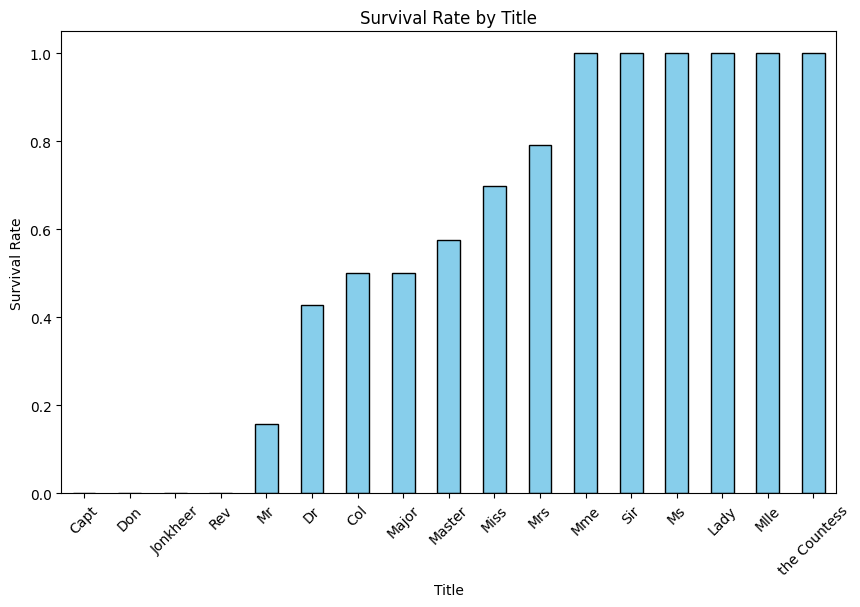

In [38]:
title_survival = playing_df.groupby('titles')['survived'].mean().sort_values()

# Plot the results
plt.figure(figsize=(10, 6))
title_survival.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Title")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Title")
plt.xticks(rotation=45)
plt.show()

/var/folders/_v/wtqndz5s2cqc5nfy735t040h0000gn/T/ipykernel_27303/2226486318.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=title_counts.index, y=title_counts.values, palette="viridis", edgecolor="black")


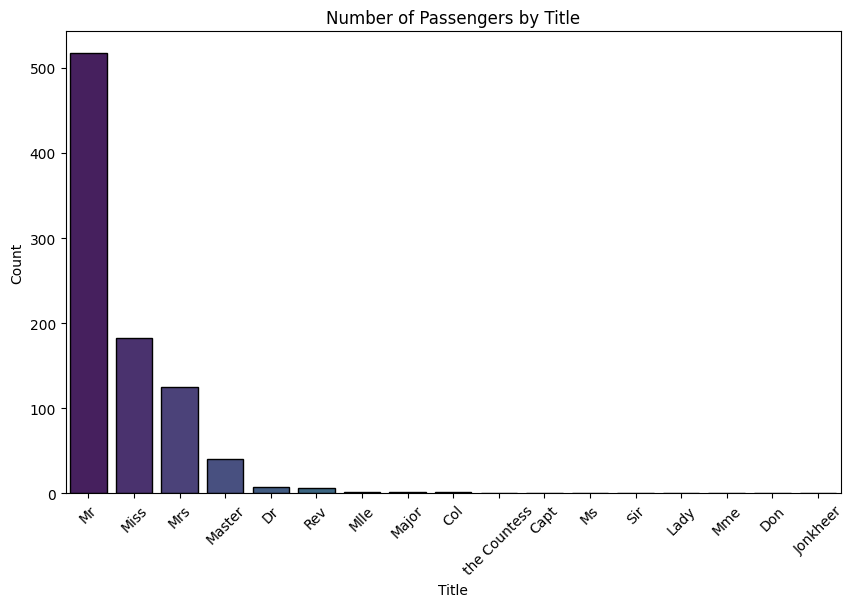

In [50]:
plt.figure(figsize=(10, 6))
title_counts = playing_df['titles'].value_counts()
sns.barplot(x=title_counts.index, y=title_counts.values, palette="viridis", edgecolor="black")

# Labels and title
plt.xlabel("Title")
plt.ylabel("Count")
plt.title("Number of Passengers by Title")
plt.xticks(rotation=45)
plt.show()

In [39]:
len(names)

891

In [40]:
names[names.isna()]

Series([], Name: Name, dtype: object)

In [41]:
titles = {re.search(r", ([A-Za-z ]+)\.", name).group(1) if re.search(r", ([A-Za-z ]+)\.", name) else name for name in names}

print(titles)

{'Ms', 'Lady', 'Major', 'Don', 'Capt', 'Sir', 'Col', 'the Countess', 'Mme', 'Mr', 'Mlle', 'Jonkheer', 'Mrs', 'Dr', 'Master', 'Rev', 'Miss'}
